# Noise Filtering for XENONnT Waveforms

Sam Li, Rice U.

In this notebook, we are going to introduce different filters to reduce noise for XENON waveforms. The goal is to effectively reduce noise, or in other words, increase SNR; in this way we won't harm the quality of signals in future analytic operations, ie: Compression. 

Firstly, import necessary libraries. 

In [10]:
import random
import strax
import straxen
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy import signal

With necessary packages imported, let load some data and take a look at it:

Experiment 180219_0946 is an experiment that records noises in the channel. Each sample in rr_noise is a long signal where no pulse should be seen. We are loading this data to understand the properties of noises. 

Experiment 180215_1035 on the other hand, is a hour-long recording that contains several high quality data. It will be out primary material to study with. 

In [2]:
st = straxen.contexts.xenon1t_dali()
rr_noise = st.get_array('180219_0946','raw_records', seconds_range=(0, 0.1))
rr = st.get_array('180215_1035','raw_records', seconds_range=(0, 0.1))

To understand the structure of our data, we can do the following:

In [375]:
st.data_info('raw_records')

,Field name,Data type,Comment
0,time,int64,Start time since unix epoch [ns]
1,length,int32,Length of the interval in samples
2,dt,int16,Width of one sample [ns]
3,channel,int16,Channel/PMT number
4,pulse_length,int32,Length of pulse to which the record belongs (w...
5,record_i,int16,Fragment number in the pulse
6,baseline,int16,Baseline determined by the digitizer (if this ...
7,data,"('<i2', (110,))",Waveform data in raw ADC counts


In [3]:
rr[0]

(1518690942000126790, 104, 10, 113, 104, 0, 0, [16008, 16016, 16009, 16013, 16003, 16012, 16005, 16008, 15999, 16008, 16002, 16009, 16000, 16009, 16004, 16014, 16004, 16012, 16006, 16015, 16009, 16015, 16005, 16013, 16005, 16013, 16006, 16008, 16002, 16005, 16001, 16010, 16007, 16011, 16003, 16009, 16005, 16014, 16008, 16015, 16007, 16012, 16008, 16014, 16008, 16011, 16003, 16010, 16003, 16008, 15982, 15938, 15976, 16003, 16000, 16007, 16002, 16012, 16004, 16012, 16006, 16012, 16005, 16010, 16001, 16011, 16002, 16007, 16001, 16008, 16003, 16008, 16001, 16009, 16004, 16011, 16006, 16014, 16007, 16014, 16006, 16010, 16004, 16011, 16006, 16012, 16006, 16010, 16003, 16007, 16002, 16009, 16003, 16009, 16003, 16012, 16008, 16014, 16008, 16013, 16004, 16011, 16005, 16013,     0,     0,     0,     0,     0,     0])

To improve the quality of our data, we can do some quick processing to rr:

In [4]:
record = strax.raw_to_records(rr)
record_noise = strax.raw_to_records(rr_noise)

strax.baseline(record)
strax.baseline(record_noise)

#Here we define two variables, sample noise and sample data, representing the 0th sample of noise recordings in
#channel 0 and the 0th sample of signal recordings in channel 0. 
sample_noise = record_noise[0]
sample_data = record[record["channel"] == 0][0]


# 1. 1D Gaussian Filter

Now let's begin filtering. By assumption, we would say that noises in our channel is gaussian, one of the best guesses for random noises. Therefore applying a 1D gaussian filter will be reasonble. 

The scipy 1D gaussian filter takes a input signal, and a sigma value that determine the degree of filtering. As a general approach, we should pick sigma to be 3 times of the standard deviation of noises (sample_noise) to gain satisfying results. 

So the hyperparameter to optimize is the sigma above which we specify a hit

**TODO: speed of computation** Show a loop of this over 10,000 records and compute the time per waveform on average that this takes.
**Can we vectorize this over one channel or concatenate records to make this go faster?**

**Axis labels, title about which filter**

**Does signal.find_peaks find DPEs (double photoelectrons?)**

**TODO: Quality check**: 
- Plot histogram over all records of the change in the total summed area of the hit
- Calculate what percentage of peaks aren't found by `signal.find_peaks()` because this differs from out traditional hitfinder mechanism, so is it consistent? 

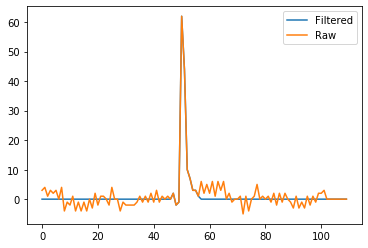

In [9]:
ft = scipy.ndimage.filters.gaussian_filter1d(sample_data[-1], 3*np.std(sample_noise[-1]))

#After filtering, we locates the peaks in the remaining signal. By now all noise terms should already be 
#eliminated. Therefore the leftover peaks should be the location of the pulses. 
peaks, _ = signal.find_peaks(ft)

#Now we keep the 5 nearest neighbors of each peak, and set the rest of the signal to be 0, where we think 
#are positions of noises. 
result = [0]*110
for peak in peaks:
    result[peak-5:peak+5] = sample_data[-1][peak-5:peak+5]

#Let's plot them and see results. 
plt.plot(result, label='Filtered')
plt.plot(sample_data[-1], label='Raw')
plt.legend()
plt.show()

To verify that this approach works, let's randomly find another sample in record to examine it out. 

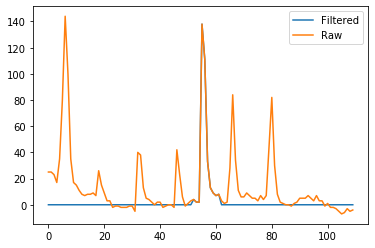

In [16]:
# import random at the beginning not here.
ch0 = record[record["channel"] == 0]
ran_index = random.randrange(0, len(ch0))
#print (ran_index)

ft_new = scipy.ndimage.filters.gaussian_filter1d(ch0[ran_index][-1], 3*np.std(sample_noise[-1]))
peaks, _ = signal.find_peaks(ft_new)

result = np.array([0]*110)
for peak in peaks:
    result[peak-5:peak+5] = ch0[ran_index][-1][peak-5:peak+5]

plt.plot(result, label='Filtered')
plt.plot(ch0[ran_index][-1], label='Raw')
plt.legend()
plt.show()

Great results. Please note that this approch is channel-specfic: using noise samples from other channels might result in problematic filtering. 

We will provide the python function for each record (multiple samples at once) in a seperate python file. Function name will be called straxen.gaussian_filter(). 

Let's look at some other filters. The very first two filters people usually come up with are mean and median filters in image processing. Let's try them out: 

# 2. Median Filter
TODO: Write a line or two about how this is done

**Label which is filtered and which isn't**

**Plot axes, legend, labels, titles**

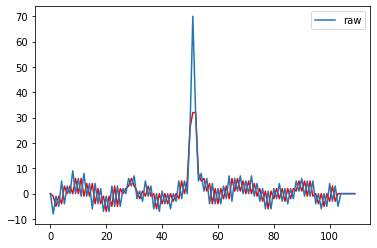

In [17]:
#Firstly we are going to implement a median filter:
from scipy.signal import medfilt
#taking record[0] as an example
med_filtered_example = medfilt(record[0][-1])
plt.plot(med_filtered_example,color="red")
plt.plot(record[0][-1], label='raw')
plt.legend()
plt.show()

The plot above shows the median-filtered signal in red and the unfiltered original signal in blue. Upon inspection we know that although noises are reduced, so does the pulse peaks(that we are looking for). Therefore median filter is not the ideal solution for us, although it's widely used in the field of image processing.  

# 3. Mean Filter

**You know the drill. better formatting, explain or link to source code what this filter does**

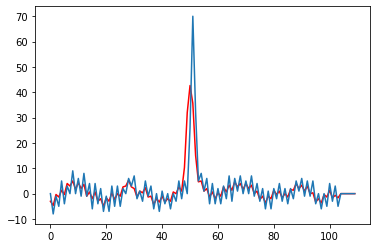

In [387]:
#Now let's implement a simple mean filter:
def runningMeanFast(x, N):
    return np.convolve(x, np.ones((N,))/N)[(N-1):]
plt.plot(runningMeanFast(record[0][-1], 3), color="red")
plt.plot(record[0][-1])
plt.show()

Similar to what a median filter does, this filter averages and reduce the noise but also hurts the signal. With larger moving average coeffcient, the signal might be worsely disturbed. In this case, the SNR is not reduced and it should not be considered as our top choice of filtering. 

# 4. High and Low Pass Filters

Now let's look at the de-nosing problem from another prospective: As we saw earlier in the waveform, each piece of data contains one/multiple pulses and a series of channel noises. Due to the fact that channel noises are generated by the hardware power amplifers, the noises must have different frequencies than the actual signals. With this property, we can reduce noise level by using High-Pass/Low-Pass Filters. 

**You know the drill. better formatting, explain or link to source code what this filter does**

Add axes. Title. Labels. Explanation of what you're plotting

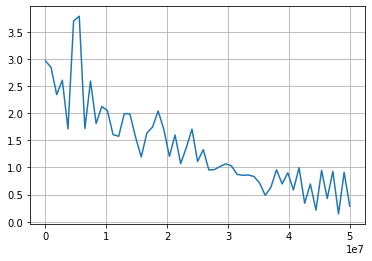

In [19]:
from scipy import signal
from scipy.fft import fft
from scipy.signal import butter, lfilter

N = 110
# sample spacing
T = 1e-8
x = np.linspace(0.0, N*T, N)
sample = record[0][-1]
yf = fft(sample)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.show()

Sadly, if we look at the frequency specturm above, it's hard to see how noises are different from pulses (we are trying to find) in the frequency domain. But still, let's try some frequency based high-pass filtering: 

**Format plot**

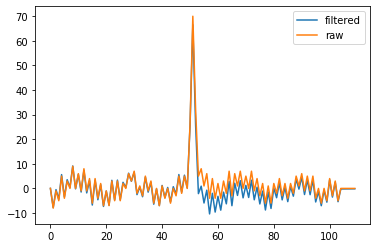

In [20]:
fs = 1e8 
cutoff = 0.1e7 # 10 MHz
B, A = butter(1, cutoff / (fs / 2), btype='high') # 1st order Butterworth low-pass
filtered_signal = lfilter(B, A, record[0][-1], axis=0)
plt.plot(filtered_signal, label='filtered')
plt.plot(record[0][-1], label='raw')
plt.legend()
plt.show()

It's doing almost nothing. While some of the terms are indeed removed, determine the right cutoff frequency (band) is hard and time-consuming. Moreover, it's not applicable. Therefore, we have to sadly abadon this frequency based filtering proposal, although this is a very good approach in many other cases. 

# 5. Weiner Filter

Finally, apart from frequency-based filters, Wiener filter is also used frequently for de-nosing. Wiener filters will detect noises, and reduce the standard deviation of noise. To use it, see the code below:

**Format plots again as before. Link code or an article with explanation. Summarize method how it works, at least in 1-2 sentences**

/home/sophiaandaloro/.local/lib/python3.8/site-packages/scipy/signal/signaltools.py:1456: RuntimeWarning: divide by zero encountered in true_divide
  res *= (1 - noise / lVar)
/home/sophiaandaloro/.local/lib/python3.8/site-packages/scipy/signal/signaltools.py:1456: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)


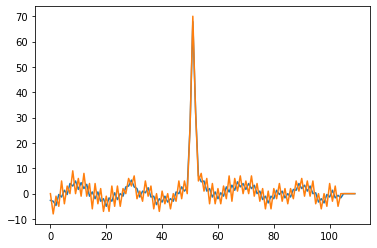

In [21]:
w_filtered = signal.wiener(record[0][-1])
plt.plot(w_filtered) #filtered
plt.plot(record[0][-1]) #original signal

This is nice. Compare with the previous gaussian filter approach, this wiener approach is more conservative, and takes less effort (won't have to specify noise for each channel). 

The gaussian filter above is, on the other hand, more aggresive, and should be used when storage is not enough. Finally let's time wiener filtering for the full record:

In [22]:
%%time
def wiener_filter(record):
    cp = record.copy()
    for item in cp:
        Wiener_filtered = signal.wiener(item[-1])
        item[-1] = Wiener_filtered
    return cp

record_filtered = wiener_filter(record)

/home/sophiaandaloro/.local/lib/python3.8/site-packages/scipy/signal/signaltools.py:1456: RuntimeWarning: divide by zero encountered in true_divide
  res *= (1 - noise / lVar)
/home/sophiaandaloro/.local/lib/python3.8/site-packages/scipy/signal/signaltools.py:1456: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)
/home/sophiaandaloro/.local/lib/python3.8/site-packages/scipy/signal/signaltools.py:1456: RuntimeWarning: invalid value encountered in true_divide
  res *= (1 - noise / lVar)


CPU times: user 2.01 s, sys: 56 ms, total: 2.07 s
Wall time: 2.03 s


This runtime is similar to gaussian filter (~1.5s); the difference is that gaussian reduces more features while wiener keeps them. 

# 6. Other Methods

In the end, there are still other filtering methods on the market, for exmaple, pypi library noisereduce, adaptive filters etc. But all these other options are way slower than the approaches above (similar to using NN). Readers are more than welcomed to practice them, while we believe that gaussian and wiener filters are enough for the purpose of XENONnT processing. 

gaussian and wiener filters will be implemented in another python file and commited to strax. Users are expected to access them shortly. 

**Sophia Andaloro comments**
- References
- Explain in 1-3 sentences each method,. pros cons 
- For each one, plot average residual at each channel 
- "scan" even in for-loop this method over all channels, plot the quantities of interest per channel
- ONE of these semi-supervised, mainly I think **noisereduce** or **adaptive filters** is worth a 1/2 day investigation (or maybe even 10 minutes) 

**Matched filter should be included here (as it's the baseline method we're comparing against**